Here I present a deterministic minimal cut solution using Stoer-Wagner algorithm. Tha idea is modified the quantum circuiti graph,  with the aim that the minimum cut passes between the two specific qubits. The algorithm is based on the following steps:

The following are a functions to draw a graph of a random quantun circuit. 

In [620]:
from qiskit import QuantumCircuit
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to plot the circuit graph
def draw_circuit_graph(G, pos):
    plt.figure(figsize=(7, 7))
    
    node_colors = []
    for node in G.nodes():
        if node.startswith('q_'):
            node_colors.append('lightgreen')  
        else:
            node_colors.append('skyblue')   

    labels = nx.get_edge_attributes(G, 'weight')

    nx.draw(G, pos, with_labels=True,
            labels=nx.get_node_attributes(G, 'label'),
            node_color=node_colors, edge_color="black",
            node_size=800, font_size=9, font_weight="bold", width=2)

    name = "circuit"
    plt.title("Graph Representing the Circuit " + name)
    plt.show()


def random_circuit_to_graph(n_qubits, depth):
    G = nx.Graph()
    pos = {}

    # Add nodes for each qubit and labels on the nodes
    qubit_top_nodes = []
    for qubit in range(n_qubits):
        qubit_top_node = f'q_top_{qubit}'
        G.add_node(f'q_{qubit}', label=f'q_{qubit}')
        G.add_node(qubit_top_node, label=f'q_{qubit}')
        qubit_top_nodes.append(qubit_top_node)
        pos[f'q_{qubit}'] = (qubit, 0)  
        pos[f'q_top_{qubit}'] = (qubit, depth + 2)  
        
    gate_counter = 0
    previous_gate_nodes = {}
    gates = []
    
    for _ in range(depth):  # Generate random gates by 'depth'
        # Choose two random consecutive qubits
        qubit1 = random.randint(0, n_qubits - 2)  
        qubit2 = qubit1 + 1  
        gates.append((qubit1, qubit2))  
        
        gate_id = f'gate_{gate_counter}'
        G.add_node(gate_id, label=gate_id)
        
        pos_gate = ((qubit1 + qubit2) / 2, gate_counter + 1)
        pos[gate_id] = pos_gate 

        # Create connections with qubits
        for qubit_index in [qubit1, qubit2]:
            if qubit_index == 0 or qubit_index == n_qubits - 1:
                if qubit_index in previous_gate_nodes:
                    if G.has_edge(gate_id, previous_gate_nodes[qubit_index]):
                        G[gate_id][previous_gate_nodes[qubit_index]]['weight'] = float('inf')
                        G[gate_id][previous_gate_nodes[qubit_index]]['weight'] += 1
                    else:
                        G.add_edge(gate_id, previous_gate_nodes[qubit_index], weight=float('inf'))
                else:
                    G.add_edge(gate_id, f'q_{qubit_index}', weight=float('inf'))
            else:
                if qubit_index in previous_gate_nodes:
                    if G.has_edge(gate_id, previous_gate_nodes[qubit_index]):
                        G[gate_id][previous_gate_nodes[qubit_index]]['weight'] += 1
                    else:
                        G.add_edge(gate_id, previous_gate_nodes[qubit_index], weight=1)
                else:
                    G.add_edge(gate_id, f'q_{qubit_index}', weight=1)

            previous_gate_nodes[qubit_index] = gate_id

        gate_counter += 1

    # Connect the final nodes of the gates with the higher qubits
    for qubit_index in range(n_qubits):
        if qubit_index == 0 or qubit_index == n_qubits - 1:
            if qubit_index in previous_gate_nodes:
                G.add_edge(previous_gate_nodes[qubit_index], f'q_top_{qubit_index}', weight=float('inf'))
            else:
                G.add_edge(f'q_{qubit_index}', f'q_top_{qubit_index}', weight=float('inf'))
        else:
            if qubit_index in previous_gate_nodes:
                G.add_edge(previous_gate_nodes[qubit_index], f'q_top_{qubit_index}', weight=1)
            else:
                G.add_edge(f'q_{qubit_index}', f'q_top_{qubit_index}', weight=1)

    return G, pos, gates


# Create a circuit given the gates
def gates_to_circuit(n_qubits, gates):
    qc = QuantumCircuit(n_qubits)
    for qubit1, qubit2 in gates:
        qc.cx(qubit1, qubit2)
    return qc

The min_cut function modified the graph to ensure that the minimum cut passes between the two specific qubits.

In [582]:
def min_cut(G, cut):
    
    u, v = cut
    G = G.copy()
    n_qubits = sum([1 for node in G.nodes() if node.startswith('q_top')])

    # Connect the qubits in the top row
    for i in range(n_qubits - 1):
        if u != i and v != i+1:
            G.add_edge(f'q_top_{i}', f'q_top_{i+1}', weight=float('inf'))
        else:
            G.add_edge(f'q_top_{i}', f'q_top_{i+1}', weight=0)
            
    # Merge the qubits with the first gate
    for i in range(n_qubits):
        for node in G.neighbors(f'q_{i}'):
            G = nx.contracted_nodes(G, node, f'q_{i}', self_loops=False)
            break

    cut_value, partition = nx.stoer_wagner(G)
    return cut_value

Example of the usage of the functions to find the minimum cut between two qubits

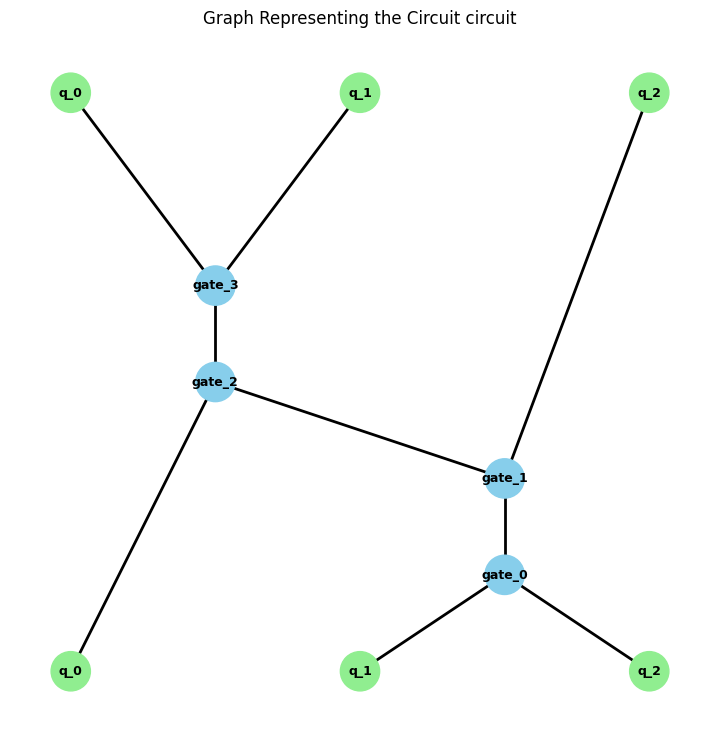

cut value: 1


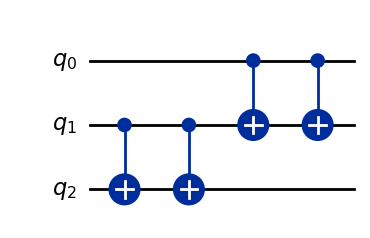

In [583]:
n_qubits = 3
gates = 4
cut = [1, 2]

# Create the graph and the circuit

G, pos, gates = random_circuit_to_graph(n_qubits, gates)

# Draw graph 
draw_circuit_graph(G, pos)

# Draw circuit
qc = gates_to_circuit(n_qubits, gates)

# Calculate the min cut value
cut_value = min_cut(G, cut)

print("cut value:", cut_value)

# Show the circuit and graph
display(qc.draw(output='mpl'))
plt.show()


Implementing the Stoer-Wagner algorithm to find the minimum cut on a quantum circuits with 3 qubits. The probability density in this case is given by a binomial distribution.

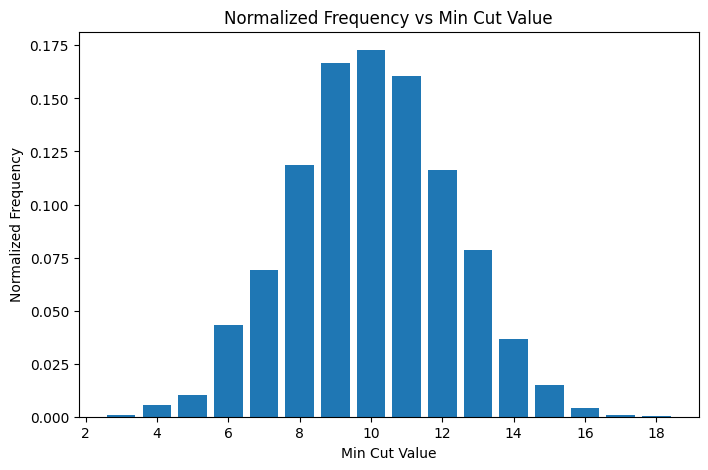

In [610]:
iteration = 5000
depth = 20
n_qubits = 3
cut = [0, 1]

cut_values = []
for _ in range(iteration):
    G, pos, gates = random_circuit_to_graph(n_qubits, depth)
    cut_value = min_cut(G, cut)
    cut_values.append(cut_value)
    
from collections import Counter
cut_count = Counter(cut_values)

total_iterations = len(cut_values)
normalized_freq = {k: v / total_iterations for k, v in cut_count.items()}

sorted_cut_values = sorted(normalized_freq.keys())
sorted_frequencies = [normalized_freq[val] for val in sorted_cut_values]

plt.figure(figsize=(8, 5))
plt.bar(sorted_cut_values, sorted_frequencies)
plt.xlabel('Min Cut Value')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Frequency vs Min Cut Value')
plt.show()

The most probable cut is given by 1/2 # gates. So the slope of cut value against depth is 1/2


Slope of the line: 0.5031153846153846


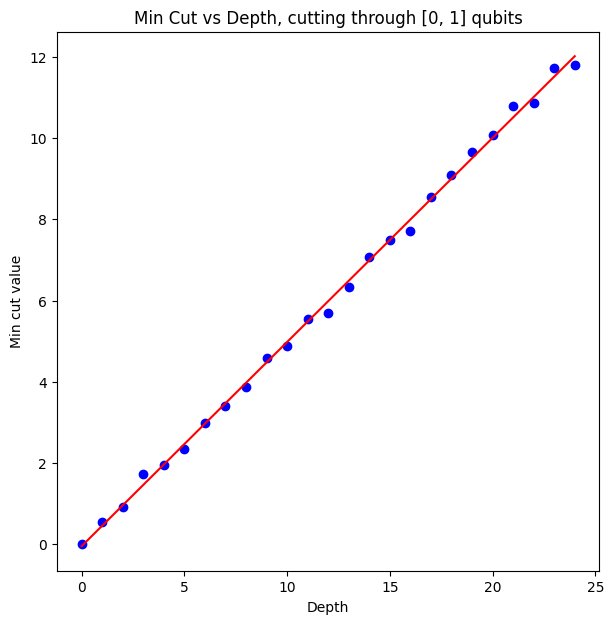

In [ ]:
iteration = 100
n_qubits = 3
depth = 25
cut = [0, 1]

# Calculate the min cut average value for multiple iterations and multiple number of gates
data = []
for gate in range(depth):
    cut_values = []
    for _ in range(iteration):
        G, pos, gates = random_circuit_to_graph(n_qubits, gate)
        cut_values.append(min_cut(G, cut))
    data.append((gate, np.mean(cut_values)))
    

#calculate the slope of the line
data = np.array(data)
m, c = np.polyfit(data[:, 0], data[:, 1], 1)

plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], color='blue')
plt.title(f'Min Cut vs Depth, cutting through {cut} qubits')
plt.xlabel('Depth')
plt.ylabel('Min cut value')

plt.plot(data[:, 0], m * data[:, 0] + c, color='red')

print("Slope of the line:", m)